In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

In [2]:
loaded_arr = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]


import numpy as np
Nx = 201
Ny = 101
Nz = 101
# Zmax = 0.05 Nz=101 quizas menos
xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [3]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity #/ 1000 #DIVIDIRRRR
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
#P = incident_pressure_plot.copy()
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

In [4]:
I = (IPP_abs)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

In [6]:
Q = 2 * alpha * I
bordes_x = 50 #queda de 2*bordes_x+1
bordes_y = 25
Q_copy = Q.copy()

Q = [corte[51-bordes_y: 51+bordes_y+1, 101-bordes_x: 101+bordes_x+1] for corte in Q_copy]
Q = Q[51-bordes_y: 51+bordes_y+1]
Q = np.array(Q)

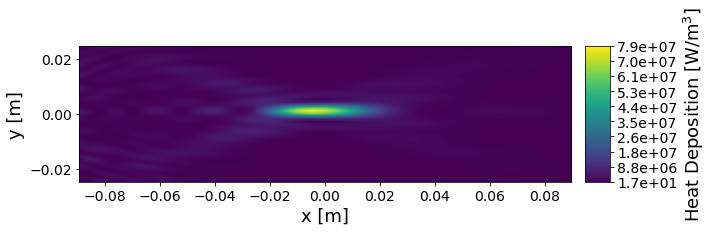

In [7]:
Q_medio = Q[25]
fig = surface_plot(Q_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(Q_medio),np.max(Q_medio)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

## 1. Parametrizar amortiguamiento

In [40]:
def pulso_rectangular(t, pd = 2e-3, pri = 4e-3): #t tiene que ser múltiplos de delta_t
    #delta_t = pd / 100
    #Nt = int(pt / delta_t)
    #iter_totales_periodo = int(pri / delta_t)
    #iter_actual = int(t / delta_t)
    
    t_res = t % pri
    if t_res < pd:
        return 1
    return 0

In [144]:
def pulso_rect(t, pd = 2e-3, pri = 4e-3):
    t_pulso = np.remainder(t, pri)
    indicator = t_pulso < pd
    amplitud = np.zeros_like(t)
    amplitud[indicator] = 1
    return amplitud

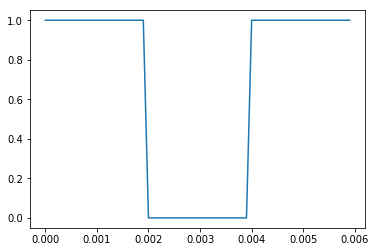

In [145]:
tie = np.arange(0, 6e-3, 1e-4)
amplitud_pulso = pulso_rect(tie)
plt.plot(tie, amplitud_pulso)

In [146]:
pulso_rect(5)

array(0)

In [138]:
tie = [i / 10000 for i in range(60)]
tie_pulso = [pulso_rectangular(t, pd = 2e-3) for t in tie]

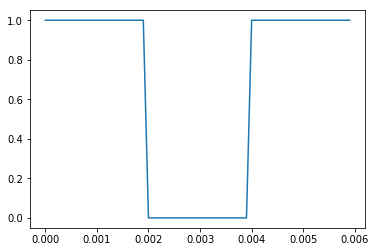

In [139]:
plt.plot(tie, tie_pulso)

In [161]:
def pulso_ramp(t, pd = 3.25e-3, pri = 4e-3, rd = 1e-3):
    t_res = t % pri
    if t_res > pd:
        return 0
    elif t_res < rd:
        return np.sin(np.pi * (2 * t_res - rd) / (2 * rd)) / 2 + 0.5
    elif t_res > (pd - rd):
        return np.sin(np.pi / 2 + np.pi * (t_res - pd + rd) / rd) / 2 + 0.5
    return 1

In [169]:
def pulso_turk(t, pd = 3.25e-3, pri = 4e-3, rd = 1e-3):
    t_pulso = np.remainder(t, pri)
    
    indicator_1 = t_pulso < rd
    indicator_2 = np.logical_and(t_pulso < pd - rd, t_pulso >= rd)
    indicator_3 = np.logical_and(t_pulso >= pd - rd, t_pulso < pd)
    
    amplitud = np.zeros_like(t)
    amplitud[indicator_2] = 1
    amplitud[indicator_1] = np.sin(np.pi * (2 * t_pulso[indicator_1] - rd) / (2 * rd)) / 2 + 0.5
    amplitud[indicator_3] = np.sin(np.pi / 2 + np.pi * (t_pulso[indicator_3] - pd + rd) / rd) / 2 + 0.5
    
    return amplitud

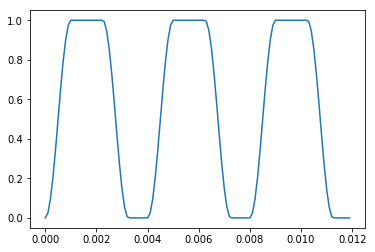

In [171]:
tie = np.arange(0, 12e-3, 1e-4)
amplitud_pulso = pulso_turk(tie)
plt.plot(tie, amplitud_pulso)

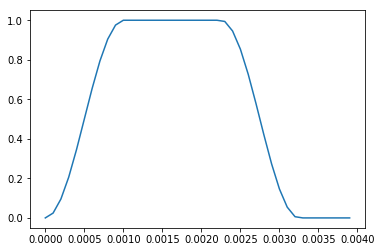

In [162]:
tie = [i / 10000 for i in range(40)]
#tie_pulso_r = [pulso_ramp(t, pd = 2e-3, pri = 4e-3, rd = 1e-3) for t in tie]
tie_pulso_r = [pulso_ramp(t) for t in tie]

plt.plot(tie, tie_pulso_r)

## 2. Correr comparación para harto tiempo

In [71]:
Nx = 2 * bordes_x + 1
Ny = 2 * bordes_y + 1
Nz = Ny

t_0 = 37
T_0 = np.zeros_like(Q) + t_0

In [75]:
delta_t = 2e-2
Nt = int(3e4)

tiempos = np.array(range(Nt))
tiempos = tiempos * delta_t

def next_it_numpy_am(T, Q, am): #am es amortiguador en ese tiempo
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E * am +
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [74]:
tiempos = np.array(range(Nt))
tiempos = tiempos * delta_t

def get_am(iteracion):
    if iteracion % 200 < 100:
        return 1
    else:
        return 0

In [77]:
%%time
temps_am = []
temps_no_am = []
T_prev_am = T_0
T_prev_no_am = T_0
for i in range(Nt):
    am = get_am(i)
    temps_am.append(np.max(T_prev_am))
    temps_no_am.append(np.max(T_prev_no_am))
    T_prev_am = next_it_numpy_am(T_prev_am, Q, am)
    T_prev_no_am = next_it_numpy_am(T_prev_no_am, Q, 1)
    
#temps_am.append(np.max(T_prev_am))
#temps_no_am.append(np.max(T_prev_no_am))

CPU times: user 17min 12s, sys: 0 ns, total: 17min 12s
Wall time: 17min 12s


In [79]:
temps_no_am = np.array(temps_no_am)
temps_am = np.array(temps_am)

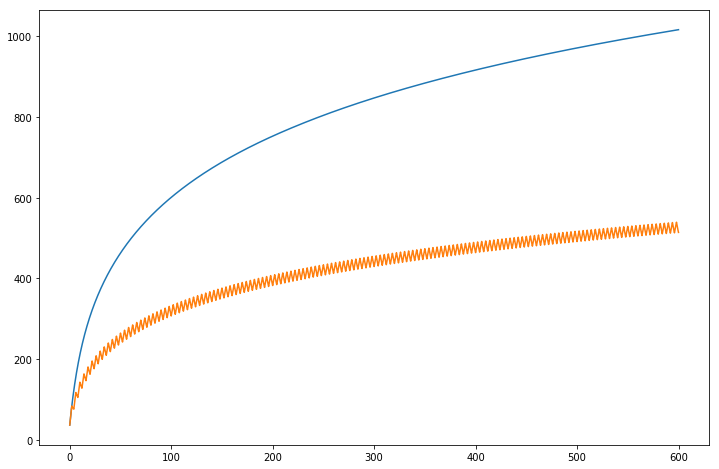

In [80]:
fig = plt.figure(figsize = (12,8))
#tiempos = np.arange(Nt + 1) * delta_t 
plt.plot(tiempos, temps_no_am)
plt.plot(tiempos, temps_am)

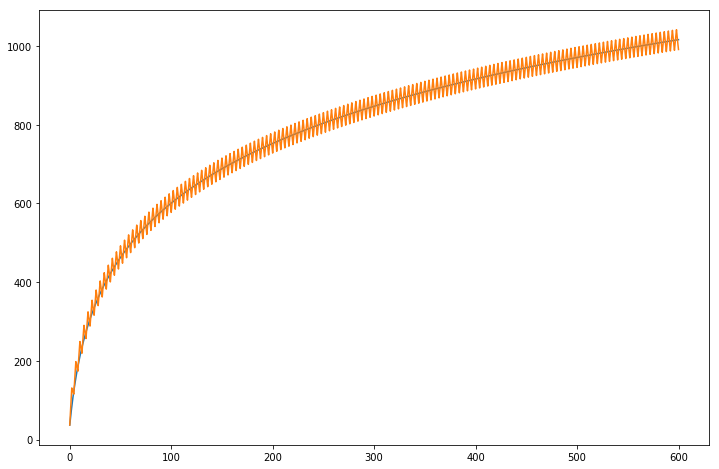

In [84]:
fig = plt.figure(figsize = (12,8))
#tiempos = np.arange(Nt + 1) * delta_t 
plt.plot(tiempos, temps_no_am)
plt.plot(tiempos, 37 + 2 * (temps_am - 37))

## 3. Ultima figura

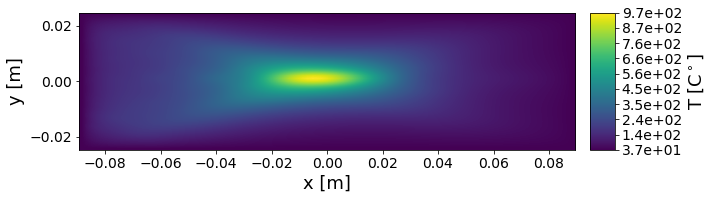

In [85]:
T_medio = T_prev_no_am[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_medio),np.max(T_medio)],
                   colorbar_unit="T [C$^\circ$]",
                   )

In [88]:
T_prev = T_prev_no_am
T_ret = np.zeros_like(T_prev_no_am) + t_0
A = - 2 * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
B = (delta_x ** (-2))
C = (delta_y ** (-2))
D = (delta_z ** (-2))
T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (T_prev[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                                (T_prev[1:Nz-1, 1:Ny-1, 0:Nx-2] + T_prev[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                                (T_prev[1:Nz-1, 0:Ny-2, 1:Nx-1] + T_prev[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                                (T_prev[0:Nz-2, 1:Ny-1, 1:Nx-1] + T_prev[2:Nz, 1:Ny-1, 1:Nx-1]) * D)

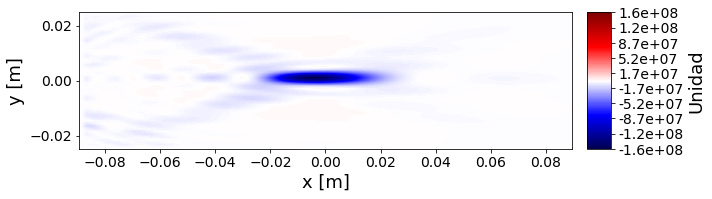

In [89]:
T_medio = T_ret[25]
fig = surface_plot(T_medio,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='seismic',
                   colormap_lims=[-np.max(abs(T_medio)),np.max(abs(T_medio))],
                   colorbar_unit="Unidad",
                   )

## 4. Comparar corridas con distintas funciones

In [102]:
delta_t = 2e-5
Nt = int(1.5e4) # cambiar a 4

t_ramp = []
t_rect = []
t_noam = []

T_ramp = T_0
T_rect = T_0
T_noam = T_0

tiempos = np.array(range(Nt)) * delta_t

In [103]:
%%time
for i in tiempos:
    ramp = pulso_rectangular(i)
    rect = pulso_ramp(i)
    noam = 1
    
    t_ramp.append(np.max(T_ramp))
    t_rect.append(np.max(T_rect))
    t_noam.append(np.max(T_noam))
    
    T_ramp = next_it_numpy_am(T_ramp, Q, ramp)
    T_rect = next_it_numpy_am(T_rect, Q, rect)
    T_noam = next_it_numpy_am(T_noam, Q, noam)
    
#temps.append(np.max(T_prev))

CPU times: user 12min 41s, sys: 18.9 ms, total: 12min 41s
Wall time: 12min 41s


In [1]:
fig = plt.figure(figsize = (12,8))

plt.plot(tiempos, t_ramp, c='red')
plt.plot(tiempos, t_rect, c='blue')
plt.plot(tiempos, t_noam, c='black')

NameError: name 'plt' is not defined

In [132]:
%%time
delta_t = 2e-2
Nt = int(3e4) 

t_ramp_2 = []
t_rect_2 = []
t_noam_2 = []

T_ramp_2 = T_0
T_rect_2 = T_0
T_noam_2 = T_0

tiempos = np.array(range(Nt)) * delta_t

for i in tiempos:
    ramp = pulso_rectangular(i, pd = 2e-1, pri = 4e-1)
    rect = pulso_ramp(i, pd = 3.25e-1, pri = 4e-1, rd = 1e-1)
    noam = 1
    
    t_ramp_2.append(np.max(T_ramp_2))
    t_rect_2.append(np.max(T_rect_2))
    t_noam_2.append(np.max(T_noam_2))
    
    T_ramp_2 = next_it_numpy_am(T_ramp_2, Q, ramp)
    T_rect_2 = next_it_numpy_am(T_rect_2, Q, rect)
    T_noam_2 = next_it_numpy_am(T_noam_2, Q, noam)

CPU times: user 27min 42s, sys: 92.3 ms, total: 27min 42s
Wall time: 2h 30min 23s


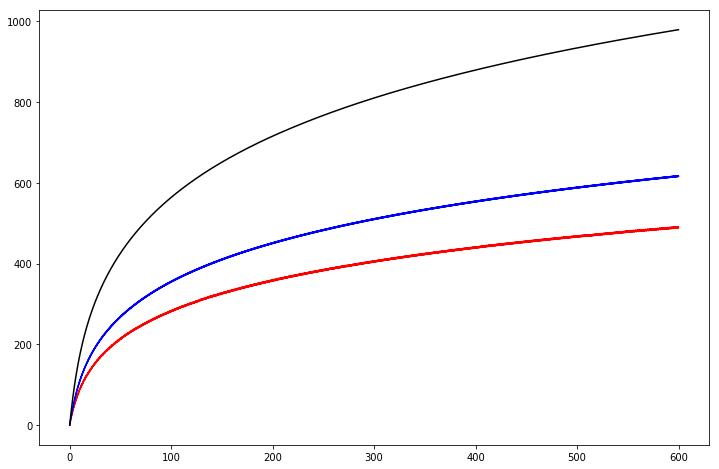

In [137]:
fig = plt.figure(figsize = (12,8))

plt.plot(tiempos, np.array(t_ramp_2) - 37, c='red')
plt.plot(tiempos, np.array(t_rect_2) - 37, c='blue')
plt.plot(tiempos, np.array(t_noam_2) - 37, c='black')

- Usar siempre numpy.
- Calcular integrales a mano y comparar en pulsos. Si pulsos tienen misma integral, deberían calentar similar. Revisar si relación es cuadrado o lineal. Revisar si es integral de pulso o integral de pulso cuadrado
- Revisar si amortiguación se hace a Q o a P.